### Importing libraries

In [1]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [2]:
# pip install keras-tuner

In [3]:
# pip install tensorboard
tensorboardPath = "C:/users/npess/appdata/roaming/python/python37/site-packages"

In [4]:
# python C:/users/npess/appdata/roaming/python/python37/site-packages/tensorflow/tensorboard/tensorboard.py --logdir=C:/Capstone/Wildfire_Detection_Capstone_697/logdir

In [5]:
# import tensorflow as tf
# # !pip install -q tf-nightly-2.0-preview
# !pip install tf-nightly-gpu-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [6]:
import os
import pandas as pd
import numpy as np
import itertools

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import altair as alt
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
# Clear any logs from previous runs
! rm -rf ./logs/
# print("GPU Available: ", tf.config.list_physical_devices('GPU'))

#sklearn
from sklearn.metrics import confusion_matrix

In [7]:
# !pip install -q tf-nightly-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [8]:
# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

### Importing and examining the images

In [9]:
def resize_image(img):
    width, height = img.size
    ratio = width/height
    new_height = 100
    new_width = int(new_height*ratio)
    img = img.resize((new_width, new_height))
    return img

In [10]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images

In [11]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [12]:
#checking out the shape for standardization
def shaping (all_images):
    width_means = []
    length_means = []
    for array in all_images:

    #     print(array.shape)

        #width to length ratio
    #     print(array.shape[0]/array.shape[1])

        #width & length means
        width_means.append(array.shape[0])
        length_means.append(array.shape[1])

    width_mean = np.mean(width_means)
    length_mean = np.mean(length_means)

    return None

In [13]:
def get_image_stats(image_arrays):
    widths = [array.shape[0] for array in image_arrays]
    lengths = [array.shape[1] for array in image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    return length_mean, length_max, width_max, width_mean

In [14]:
def load_images2(img_dir, type, height):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images 
    dir = os.getcwd()
    rootdir = '{}/assets/{}'.format(dir, img_dir)
    data = []
    try:
        images = os.listdir(rootdir)
        image_file = [file for file in images if '.DS_Store' not in file]
        try:
            image_arrays = [np.asarray(resize_image(Image.open(f'{rootdir}/{image}'))) for image in image_file]
            label_arrays = []
            for array in image_arrays:
                label_arrays.append([type])
            image_labels = label_arrays
            data.extend(list(zip(image_arrays, image_labels)))
        except:
            for subpath in os.listdir(rootdir):
                d = os.path.join(rootdir, subpath)
                images = os.listdir(d)
                image_file = [file for file in images if '.DS_Store' not in file]
                try:
                    image_arrays = [np.asarray(resize_image(Image.open(f'{d}/{image}'))) for image in image_file]
                    label_arrays = []
                    for array in image_arrays:
                        label_arrays.append([type])
                    image_labels = label_arrays
                    data.extend(list(zip(image_arrays, image_labels)))
                except:
                    for subpath in os.listdir(d):
                        d2 = os.path.join(d,subpath)
                        images = os.listdir(d2)
                        print('d2 section')
                        image_file = [file for file in images if '.DS_Store' not in file]
                        if len(image_file)>1:
                            try:
                                print('final try')
                                image_arrays = [np.asarray(resize_image(Image.open(f'{d2}/{image}'))) for image in image_file]
                                label_arrays = []
                                for array in image_arrays:
                                    label_arrays.append([type])
                                image_labels = label_arrays
                                data.extend(list(zip(image_arrays, image_labels)))
                                print(data)
                            except:
                                pass
                        else:
                            pass
    except:
        pass
    
    #get_labels
    print('data')
    print(data)

    return data

In [15]:
def load_images(img_dir, type, height, aug=False):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images
    if aug:
        image_file = img_dir
        image_arrays = [np.asarray(resize_image(image)) for image in image_file]
    else:
        dir = os.getcwd()
        images = os.listdir('{}/assets/{}'.format(dir, img_dir))
        image_file = [file for file in images if '.DS_Store' not in file]
        image_arrays = [np.asarray(resize_image(Image.open('{}/assets/{}/{}'.format(dir,img_dir, image)))) for image in image_file]
        paths = ['{}/assets/{}/{}'.format(dir,img_dir, image) for image in image_file]
#         print(paths) #for gitignore
    
    #get_labels
    label_arrays = []
    for array in image_arrays:
        label_arrays.append([type])
    image_labels = label_arrays

    data = list(zip(image_arrays, image_labels))

    return data


In [16]:
def storeImgs (datasets,folders,subfolders,smokeTypes,timeOfDay):
    data = []
    for dataset in datasets:
        if dataset.str.contains('-'):
            for smokeType in smokeTypes:
                for time in timeOfDay:
                    data.extend(load_images(f'{dataset}/{smokeType}/{time}', 1, 100))   
        else:
            data.extend(load_images({dataset}, 1, 100))
                

In [17]:
# wildfire_train_set_Unprocessed = load_images2('wildfire_train_set - Unprocessed', 1, 100)
# wildfire_test_set = load_images2('wildfire_test_set', 1, 100)
# mountain_test_set = load_images2('mountain_test_set', 1, 100)

In [18]:
wildfire_test_set = load_images('wildfire_test_set', 1, 100)
mountain_test_set = load_images('mountain_test_set', 0, 100)
nofire_unprocessed = load_images('wildfire_train_set - Base Forest - Unprocessed',0,100)
nofire_processed = load_images('wildfire_train_set - Base Forest - Processed',0,100)
smokeTypes = ['Heavy Smoke','Light Smoke']
timeOfDay = ['Night','Day','Morning']

data = []
data.extend(wildfire_test_set)
data.extend(mountain_test_set)
data.extend(nofire_unprocessed)
data.extend(nofire_processed)
for smokeType in smokeTypes:
    for time in timeOfDay:
        wildfire_train_set_Unprocessed = load_images(f'wildfire_train_set - Unprocessed/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Unprocessed)
        wildfire_train_set_Processed = load_images(f'wildfire_train_set - Processed and Pruned/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Processed)
        

In [19]:
def imageLabelAssembly(data, augment=False):

    images, labels = zip(*data)

    length_mean, length_max, width_max, width_mean = get_image_stats(images)

    #crop and pad images
    images_cropped = pad_images(images, width_max, length_max)
    images_final = crop_images(images_cropped, width_mean, length_mean)

    #convert all imagees to RGB some are ARGB
    images_final = [np.array(Image.fromarray(image).convert('RGB')) for image in images_final]

    if augment:
        data_augmentation = keras.Sequential(
          [
            layers.RandomFlip("vertical",
                              input_shape=input_shape),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
          ])
        
#         # plt.figure(figsize=(10, 10))
#         augmented_images = []
#         augmented_labels = []
#         # for images in train_images:
#         for i in range(len(train_images[:9])):
#             augmented_image = np.array(data_augmentation(tf.convert_to_tensor(images_final[i], dtype=tf.float32)))
#             augmented_label = labels[i]
#             augmented_images.append(data_augmentation(augmented_image))
#             augmented_labels.append(augmented_label)
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image).numpy().astype("uint8")
#             plt.axis("off")
            
#         plt.figure(figsize=(10, 10))
#         for i in range(9):
#             augmented_image = data_augmentation(tf.convert_to_tensor(images_final, dtype=tf.float32)[i])
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image)
#             plt.axis("off")
    else:
        pass

#     augmented = list(zip(augmented_images, augmented_labels))
    data = list(zip(images_final, labels))
    
    return data

data = imageLabelAssembly(data, augment=False)

In [20]:
def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

C:\Users\npess\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0,

In [22]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])
    
# plot_images(train_images, train_labels)
# plot_images(test_images, test_labels)

In [23]:
input_shape = train_images.shape[1:]

In [24]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [25]:
# print(train_images.shape)
# print(np.asarray(train_labels).reshape(-1).shape)

In [26]:
# train_images = tf.data.Dataset.from_tensor_slices((train_images, np.asarray(train_labels).reshape(-1)))
# test_images = tf.data.Dataset.from_tensor_slices((test_images, np.asarray(test_labels).reshape(-1)))

In [27]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))#(100, 163, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 91, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 89, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 42, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 56448)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [29]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
84/84 [==============================] - 32s 380ms/step - loss: 0.5752 - accuracy: 0.7204 - val_loss: 0.3417 - val_accuracy: 0.8537
Epoch 2/10
84/84 [==============================] - 32s 380ms/step - loss: 0.2660 - accuracy: 0.8828 - val_loss: 0.1792 - val_accuracy: 0.9284
Epoch 3/10
84/84 [==============================] - 31s 371ms/step - loss: 0.1461 - accuracy: 0.9436 - val_loss: 0.1237 - val_accuracy: 0.9612
Epoch 4/10
84/84 [==============================] - 31s 370ms/step - loss: 0.0821 - accuracy: 0.9694 - val_loss: 0.0806 - val_accuracy: 0.9642
Epoch 5/10
84/84 [==============================] - 33s 388ms/step - loss: 0.1387 - accuracy: 0.9500 - val_loss: 0.1392 - val_accuracy: 0.9463
Epoch 6/10
84/84 [==============================] - 33s 388ms/step - loss: 0.0394 - accuracy: 0.9869 - val_loss: 0.0420 - val_accuracy: 0.9851
Epoch 7/10
84/84 [==============================] - 32s 380ms/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.0579 - val_accuracy: 0.9821

In [30]:
history_df = pd.DataFrame(history.history).reset_index()
history_df = history_df.rename(columns={'index':'epoch'})
accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

In [31]:
performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
    x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
    y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
    color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#6f0000','#696969']),
    legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
    ).properties(
    width=800,
    height=300
    ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
    ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
    )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)

performanceChart

alt.Chart(...)

In [32]:
# accuracy = alt.Chart(accuracy_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Accuracy')),
#     color=alt.Color('variable'))

# loss = alt.Chart(loss_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Loss')),
#     color=alt.Color('variable'))

# alt.vconcat(accuracy,loss)


### Data augmentation

In [76]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [77]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 184, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 184, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 184, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 92, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 92, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 46, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 46, 64)       

In [37]:
epochs = 10
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/10
84/84 [==============================] - 22s 253ms/step - loss: 0.7555 - accuracy: 0.4979 - val_loss: 0.6943 - val_accuracy: 0.4985
Epoch 2/10
84/84 [==============================] - 22s 258ms/step - loss: 0.6972 - accuracy: 0.5073 - val_loss: 0.6792 - val_accuracy: 0.5104
Epoch 3/10
84/84 [==============================] - 22s 256ms/step - loss: 0.6901 - accuracy: 0.5412 - val_loss: 0.6609 - val_accuracy: 0.6328
Epoch 4/10
84/84 [==============================] - 22s 259ms/step - loss: 0.6427 - accuracy: 0.6301 - val_loss: 0.5932 - val_accuracy: 0.7224
Epoch 5/10
84/84 [==============================] - 22s 260ms/step - loss: 0.6373 - accuracy: 0.6181 - val_loss: 0.5599 - val_accuracy: 0.7463
Epoch 6/10
84/84 [==============================] - 21s 252ms/step - loss: 0.5982 - accuracy: 0.6614 - val_loss: 0.5435 - val_accuracy: 0.7552
Epoch 7/10
84/84 [==============================] - 21s 252ms/step - loss: 0.5895 - accuracy: 0.6771 - val_loss: 0.5412 - val_accuracy: 0.7552

In [40]:
history_df = pd.DataFrame(history.history).reset_index()
history_df = history_df.rename(columns={'index':'epoch'})
accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
    x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
    y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
    color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#ff7b7b','#999999']),
    legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
    ).properties(
    width=800,
    height=300
    ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
    ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
    )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)

performanceChart

alt.Chart(...)

In [41]:
predictions = model.predict(x=test_images, steps=len(test_images), verbose=0)

In [42]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment='top',
            color="black" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[139  29]
 [ 56 111]]


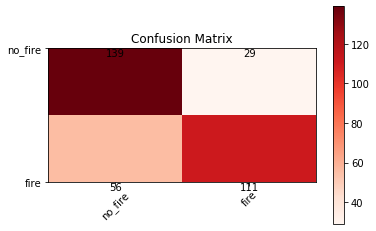

In [44]:
cm_plot_labels = ['no_fire','fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Normalized confusion matrix
[[0.82738095 0.17261905]
 [0.33532934 0.66467066]]


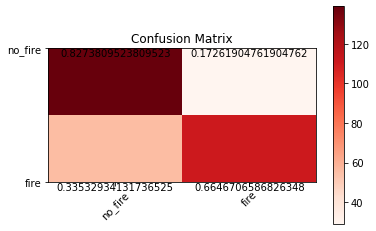

In [45]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=True, title='Confusion Matrix')

In [54]:
cmDf = pd.DataFrame(cm)
cmDf.columns = ['No fire','Fire']
cmDf.index = ['No fire','Fire']
cmDf.reset_index(inplace=True)
cmDf = cmDf.rename(columns={'index':'Labels'})
cmDf = pd.melt(cmDf, id_vars=['Labels'], value_vars=['No fire','Fire'])
cmDf

,Labels,variable,value
0,No fire,No fire,139
1,Fire,No fire,56
2,No fire,Fire,29
3,Fire,Fire,111


In [59]:
alt.Chart(cmDf).mark_rect().encode(
    x='Labels',
    y='variable',
    color='value'
)

alt.Chart(...)

## Hyperparameter tuning 

### Option 1

In [88]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([8, 16, 32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','Nadam','RMSprop','Adagrad']))

METRIC_ACCURACY = 'accuracy'

METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="loss (val.)",
    ),
    hp.Metric(
        "batch_accuracy",
        group="train",
        display_name="accuracy (train)",
    ),
    hp.Metric(
        "batch_loss",
        group="train",
        display_name="loss (train)",
    ),
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    metrics=METRICS
    )

In [109]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
#         layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [110]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [111]:
#https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/hparams_demo.py#L88

def train_test_model(hparams,epochs,augmentModel=False):
    
    if augmentModel:
        data_augmentation = augment(augment_layers)
    else:
        data_augmentation = ''
    
    
    model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ])

    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
#       metrics=['accuracy'],
      metrics=['accuracy',f1_m,precision_m, recall_m]
    )
    #############################
    #trying to drill into recall#
    #############################
    

    model.fit(train_images, train_labels, epochs=epochs) # Run with 1 epoch to speed things up for demo purposes
#     _, accuracy = model.evaluate(test_images, test_labels)
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_images, test_labels)

#     tf.print("recall:", type(recall), output_stream=sys.stdout)
    return loss, accuracy, f1_score, precision, recall

def run(run_dir, hparams, epochs, augmentModel=False):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
#         accuracy = train_test_model(hparams,epochs,augmentModel)
#         print(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1))
#         print(list(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)))

        model = train_test_model(hparams,epochs,augmentModel=True)
        
        
#         print(tf.summary.scalar(METRIC, accuracy, step=1))
#         print(list(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)))
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#     metrics=METRICS
        
    
    
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     accuracy = create_model(hparams)
#     #converting to tf scalar
#     accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# def run(data, base_logdir, session_id, hparams):
#     """Run a training/validation session.
#     Flags must have been parsed for this function to behave.
#     Args:
#       data: The data as loaded by `prepare_data()`.
#       base_logdir: The top-level logdir to which to write summary data.
#       session_id: A unique string ID for this session.
#       hparams: A dict mapping hyperparameters in `HPARAMS` to values.
#     """
#     model = model_fn(hparams=hparams, seed=session_id)
#     logdir = os.path.join(base_logdir, session_id)

#     callback = tf.keras.callbacks.TensorBoard(
#         logdir,
#         update_freq=flags.FLAGS.summary_freq,
#         profile_batch=0,  # workaround for issue #2084
#     )
#     hparams_callback = hp.KerasCallback(logdir, hparams)
#     ((x_train, y_train), (x_test, y_test)) = data
#     result = model.fit(
#         x=x_train,
#         y=y_train,
#         epochs=flags.FLAGS.num_epochs,
#         shuffle=False,
#         validation_data=(x_test, y_test),
#         callbacks=[callback, hparams_callback],
#     )

# def run_all(logdir, verbose=False):
def run_all(run_dir, verbose=False):
    """Perform random search over the hyperparameter space.
    Arguments:
      logdir: The top-level directory into which to write data. This
        directory should be empty or nonexistent.
      verbose: If true, print out each run's name as it begins.
    """
#     data = prepare_data()
    rng = random.Random(0)

    with tf.summary.create_file_writer(logdir).as_default():
        hp.hparams_config(hparams=HPARAMS, metrics=METRICS)

    sessions_per_group = 2
    num_sessions = flags.FLAGS.num_session_groups * sessions_per_group
    session_index = 0  # across all session groups
    for group_index in range(flags.FLAGS.num_session_groups):
#     for num_units in HP_NUM_UNITS.domain.values:
        hparams = {h: h.domain.sample_uniform(rng) for h in HPARAMS}
        hparams_string = str(hparams)
        for repeat_index in range(sessions_per_group):
            session_id = str(session_index)
            session_index += 1
            if verbose:
                print(
                    "--- Running training session %d/%d"
                    % (session_index, num_sessions)
                )
                print(hparams_string)
                print("--- repeat #: %d" % (repeat_index + 1))
#             run(
#                 data=data,
#                 base_logdir=logdir,
#                 session_id=session_id,
#                 hparams=hparams,
#             )
            run(
                run_dir=run_dir,
                hparams=hparams,
            )
            

In [112]:
session_num = 0
epochs = 30

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
#             for metrics in METRICS:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams, epochs, augmentModel=True)
            session_num += 1

--- Starting trial: run-0
{'num_units': 8, 'dropout': 0.1, 'optimizer': 'Adagrad'}
Epoch 1/30
84/84 [==============================] - 25s 288ms/step - loss: 2.2858 - accuracy: 0.5017 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/30
84/84 [==============================] - 25s 292ms/step - loss: 2.2641 - accuracy: 0.5069 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 3/30
84/84 [==============================] - 24s 290ms/step - loss: 2.2412 - accuracy: 0.5080 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 4/30
84/84 [==============================] - 21s 254ms/step - loss: 2.2048 - accuracy: 0.5084 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 5/30
84/84 [==============================] - 21s 250ms/step - loss: 2.1574 - accuracy: 0.4670 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 6/30
84/84 [==============================] - 21s 246ms/step - los

84/84 [==============================] - 20s 237ms/step - loss: 0.5753 - accuracy: 0.6820 - f1_m: 0.6649 - precision_m: 0.5083 - recall_m: 0.9827
Epoch 19/30
84/84 [==============================] - 20s 236ms/step - loss: 0.6083 - accuracy: 0.6726 - f1_m: 0.6623 - precision_m: 0.5059 - recall_m: 0.9841
Epoch 20/30
84/84 [==============================] - 20s 237ms/step - loss: 0.5498 - accuracy: 0.7159 - f1_m: 0.6682 - precision_m: 0.5090 - recall_m: 0.9891
Epoch 21/30
84/84 [==============================] - 20s 237ms/step - loss: 0.5449 - accuracy: 0.7171 - f1_m: 0.6656 - precision_m: 0.5087 - recall_m: 0.9884
Epoch 22/30
84/84 [==============================] - 20s 238ms/step - loss: 0.5451 - accuracy: 0.7122 - f1_m: 0.6664 - precision_m: 0.5083 - recall_m: 0.9874
Epoch 23/30
84/84 [==============================] - 20s 239ms/step - loss: 0.5367 - accuracy: 0.7074 - f1_m: 0.6653 - precision_m: 0.5064 - recall_m: 0.9886
Epoch 24/30
84/84 [==============================] - 20s 236ms/s

84/84 [==============================] - 21s 244ms/step - loss: 0.8189 - accuracy: 0.4965 - f1_m: 0.6473 - precision_m: 0.5089 - recall_m: 0.9074
Epoch 8/30
84/84 [==============================] - 20s 242ms/step - loss: 0.8245 - accuracy: 0.4968 - f1_m: 0.6297 - precision_m: 0.5025 - recall_m: 0.8815
Epoch 9/30
84/84 [==============================] - 20s 242ms/step - loss: 0.8215 - accuracy: 0.4901 - f1_m: 0.6364 - precision_m: 0.5057 - recall_m: 0.8871
Epoch 10/30
84/84 [==============================] - 20s 242ms/step - loss: 0.8224 - accuracy: 0.5151 - f1_m: 0.6391 - precision_m: 0.5062 - recall_m: 0.8878
Epoch 11/30
84/84 [==============================] - 20s 241ms/step - loss: 0.8073 - accuracy: 0.4879 - f1_m: 0.6427 - precision_m: 0.5053 - recall_m: 0.9023
Epoch 12/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7955 - accuracy: 0.5189 - f1_m: 0.6491 - precision_m: 0.5099 - recall_m: 0.9165
Epoch 13/30
84/84 [==============================] - 20s 241ms/ste

84/84 [==============================] - 21s 245ms/step - loss: 0.7857 - accuracy: 0.5054 - f1_m: 0.6376 - precision_m: 0.5041 - recall_m: 0.8882
Epoch 28/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7881 - accuracy: 0.4897 - f1_m: 0.6361 - precision_m: 0.5034 - recall_m: 0.8836
Epoch 29/30
84/84 [==============================] - 21s 247ms/step - loss: 0.7807 - accuracy: 0.5181 - f1_m: 0.6302 - precision_m: 0.4993 - recall_m: 0.8786
Epoch 30/30
11/11 [==============================] - 1s 47ms/step - loss: 0.7012 - accuracy: 0.4985 - f1_m: 0.6602 - precision_m: 0.4970 - recall_m: 1.0000
--- Starting trial: run-5
{'num_units': 8, 'dropout': 0.2, 'optimizer': 'Adagrad'}
Epoch 1/30
84/84 [==============================] - 21s 238ms/step - loss: 2.2799 - accuracy: 0.5009 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/30
84/84 [==============================] - 20s 237ms/step - loss: 2.2360 - accuracy: 0.4987 - f1_m: 0.0000e+00 - precisio

84/84 [==============================] - 20s 238ms/step - loss: 0.6936 - accuracy: 0.6215 - f1_m: 0.6514 - precision_m: 0.5059 - recall_m: 0.9367
Epoch 16/30
84/84 [==============================] - 20s 239ms/step - loss: 0.6966 - accuracy: 0.6107 - f1_m: 0.6548 - precision_m: 0.5073 - recall_m: 0.9383
Epoch 17/30
84/84 [==============================] - 20s 237ms/step - loss: 0.6690 - accuracy: 0.6275 - f1_m: 0.6581 - precision_m: 0.5096 - recall_m: 0.9514
Epoch 18/30
84/84 [==============================] - 20s 238ms/step - loss: 0.6788 - accuracy: 0.6185 - f1_m: 0.6555 - precision_m: 0.5071 - recall_m: 0.9477
Epoch 19/30
84/84 [==============================] - 20s 238ms/step - loss: 0.6680 - accuracy: 0.6271 - f1_m: 0.6561 - precision_m: 0.5082 - recall_m: 0.9472
Epoch 20/30
84/84 [==============================] - 20s 240ms/step - loss: 0.6694 - accuracy: 0.6230 - f1_m: 0.6575 - precision_m: 0.5097 - recall_m: 0.9483
Epoch 21/30
84/84 [==============================] - 20s 238ms/s

84/84 [==============================] - 19s 221ms/step - loss: 0.8985 - accuracy: 0.4853 - f1_m: 0.6285 - precision_m: 0.5121 - recall_m: 0.8428
Epoch 4/30
84/84 [==============================] - 19s 224ms/step - loss: 0.8401 - accuracy: 0.5039 - f1_m: 0.6294 - precision_m: 0.5106 - recall_m: 0.8386
Epoch 5/30
84/84 [==============================] - 19s 222ms/step - loss: 0.8035 - accuracy: 0.5200 - f1_m: 0.6470 - precision_m: 0.5165 - recall_m: 0.8861
Epoch 6/30
84/84 [==============================] - 18s 220ms/step - loss: 0.7609 - accuracy: 0.5424 - f1_m: 0.6445 - precision_m: 0.5081 - recall_m: 0.8986
Epoch 7/30
84/84 [==============================] - 19s 222ms/step - loss: 0.7073 - accuracy: 0.6025 - f1_m: 0.6507 - precision_m: 0.5074 - recall_m: 0.9265
Epoch 8/30
84/84 [==============================] - 19s 220ms/step - loss: 0.6886 - accuracy: 0.6069 - f1_m: 0.6587 - precision_m: 0.5126 - recall_m: 0.9434
Epoch 9/30
84/84 [==============================] - 19s 221ms/step - 

84/84 [==============================] - 20s 240ms/step - loss: 0.7052 - accuracy: 0.4923 - f1_m: 0.6610 - precision_m: 0.5092 - recall_m: 0.9660
Epoch 24/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7017 - accuracy: 0.5091 - f1_m: 0.6657 - precision_m: 0.5095 - recall_m: 0.9768
Epoch 25/30
84/84 [==============================] - 20s 241ms/step - loss: 0.7033 - accuracy: 0.4905 - f1_m: 0.6616 - precision_m: 0.5068 - recall_m: 0.9709
Epoch 26/30
84/84 [==============================] - 20s 241ms/step - loss: 0.7031 - accuracy: 0.4965 - f1_m: 0.6642 - precision_m: 0.5082 - recall_m: 0.9773
Epoch 27/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7019 - accuracy: 0.5002 - f1_m: 0.6624 - precision_m: 0.5073 - recall_m: 0.9704
Epoch 28/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7053 - accuracy: 0.4931 - f1_m: 0.6652 - precision_m: 0.5089 - recall_m: 0.9822
Epoch 29/30
84/84 [==============================] - 20s 240ms/s

84/84 [==============================] - 20s 240ms/step - loss: 0.5638 - accuracy: 0.6976 - f1_m: 0.6681 - precision_m: 0.5071 - recall_m: 0.9953s - loss: 0.5638 - accuracy: 0.6976 - f1_m: 0.6681 - precision_m: 0.5071 - recall_m: 0.99
Epoch 13/30
84/84 [==============================] - 20s 241ms/step - loss: 0.5477 - accuracy: 0.7193 - f1_m: 0.6646 - precision_m: 0.5057 - recall_m: 0.9899
Epoch 14/30
84/84 [==============================] - 20s 239ms/step - loss: 0.5312 - accuracy: 0.7290 - f1_m: 0.6667 - precision_m: 0.5074 - recall_m: 0.9969
Epoch 15/30
84/84 [==============================] - 20s 239ms/step - loss: 0.5303 - accuracy: 0.7256 - f1_m: 0.6688 - precision_m: 0.5081 - recall_m: 0.9969
Epoch 16/30
84/84 [==============================] - 20s 240ms/step - loss: 0.5216 - accuracy: 0.7439 - f1_m: 0.6678 - precision_m: 0.5078 - recall_m: 0.9950
Epoch 17/30
84/84 [==============================] - 20s 241ms/step - loss: 0.5054 - accuracy: 0.7559 - f1_m: 0.6698 - precision_m: 0

Epoch 1/30
84/84 [==============================] - 21s 240ms/step - loss: 0.9213 - accuracy: 0.4890 - f1_m: 0.5976 - precision_m: 0.4699 - recall_m: 0.8464
Epoch 2/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7399 - accuracy: 0.5114 - f1_m: 0.6572 - precision_m: 0.5069 - recall_m: 0.9513
Epoch 3/30
84/84 [==============================] - 20s 239ms/step - loss: 0.7335 - accuracy: 0.5080 - f1_m: 0.6532 - precision_m: 0.5049 - recall_m: 0.9472
Epoch 4/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7062 - accuracy: 0.5256 - f1_m: 0.6702 - precision_m: 0.5133 - recall_m: 0.9819
Epoch 5/30
84/84 [==============================] - 20s 240ms/step - loss: 0.6516 - accuracy: 0.6278 - f1_m: 0.6651 - precision_m: 0.5076 - recall_m: 0.9852
Epoch 6/30
84/84 [==============================] - 20s 238ms/step - loss: 0.6167 - accuracy: 0.6540 - f1_m: 0.6664 - precision_m: 0.5080 - recall_m: 0.9887
Epoch 7/30
84/84 [==============================] - 20s 23

Epoch 21/30
84/84 [==============================] - 21s 251ms/step - loss: 0.7036 - accuracy: 0.4860 - f1_m: 0.6626 - precision_m: 0.5074 - recall_m: 0.9730
Epoch 22/30
84/84 [==============================] - 21s 250ms/step - loss: 0.7018 - accuracy: 0.5121 - f1_m: 0.6650 - precision_m: 0.5082 - recall_m: 0.9816
Epoch 23/30
84/84 [==============================] - 21s 252ms/step - loss: 0.7033 - accuracy: 0.4774 - f1_m: 0.6650 - precision_m: 0.5098 - recall_m: 0.9756
Epoch 24/30
84/84 [==============================] - 21s 250ms/step - loss: 0.6999 - accuracy: 0.5039 - f1_m: 0.6629 - precision_m: 0.5079 - recall_m: 0.9779
Epoch 25/30
84/84 [==============================] - 21s 250ms/step - loss: 0.7043 - accuracy: 0.4916 - f1_m: 0.6623 - precision_m: 0.5064 - recall_m: 0.9794
Epoch 26/30
84/84 [==============================] - 21s 251ms/step - loss: 0.7006 - accuracy: 0.4946 - f1_m: 0.6653 - precision_m: 0.5080 - recall_m: 0.9840
Epoch 27/30
84/84 [==============================] -

84/84 [==============================] - 20s 244ms/step - loss: 0.7103 - accuracy: 0.4965 - f1_m: 0.6637 - precision_m: 0.5092 - recall_m: 0.9768
Epoch 9/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7058 - accuracy: 0.4994 - f1_m: 0.6634 - precision_m: 0.5094 - recall_m: 0.9718
Epoch 10/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7091 - accuracy: 0.4871 - f1_m: 0.6581 - precision_m: 0.5051 - recall_m: 0.9621
Epoch 11/30
84/84 [==============================] - 21s 244ms/step - loss: 0.7051 - accuracy: 0.5114 - f1_m: 0.6648 - precision_m: 0.5090 - recall_m: 0.9790
Epoch 12/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7082 - accuracy: 0.5248 - f1_m: 0.6626 - precision_m: 0.5080 - recall_m: 0.9722
Epoch 13/30
84/84 [==============================] - 20s 242ms/step - loss: 0.6992 - accuracy: 0.5162 - f1_m: 0.6657 - precision_m: 0.5078 - recall_m: 0.9859
Epoch 14/30
84/84 [==============================] - 20s 241ms/st

84/84 [==============================] - 20s 238ms/step - loss: 0.5326 - accuracy: 0.7327 - f1_m: 0.6659 - precision_m: 0.5070 - recall_m: 0.9881
Epoch 29/30
84/84 [==============================] - 20s 239ms/step - loss: 0.5318 - accuracy: 0.7350 - f1_m: 0.6662 - precision_m: 0.5078 - recall_m: 0.9867
Epoch 30/30
11/11 [==============================] - 1s 45ms/step - loss: 0.4552 - accuracy: 0.7940 - f1_m: 0.6602 - precision_m: 0.4970 - recall_m: 1.0000
--- Starting trial: run-18
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/30
84/84 [==============================] - 21s 242ms/step - loss: 0.9604 - accuracy: 0.4938 - f1_m: 0.5726 - precision_m: 0.4549 - recall_m: 0.7932
Epoch 2/30
84/84 [==============================] - 20s 239ms/step - loss: 0.7456 - accuracy: 0.5095 - f1_m: 0.6537 - precision_m: 0.5086 - recall_m: 0.9367
Epoch 3/30
84/84 [==============================] - 20s 241ms/step - loss: 0.7327 - accuracy: 0.5039 - f1_m: 0.6574 - precision_m: 0.5085 - reca

84/84 [==============================] - 21s 246ms/step - loss: 0.7227 - accuracy: 0.4983 - f1_m: 0.6509 - precision_m: 0.5049 - recall_m: 0.9347
Epoch 17/30
84/84 [==============================] - 21s 246ms/step - loss: 0.7148 - accuracy: 0.5211 - f1_m: 0.6568 - precision_m: 0.5068 - recall_m: 0.9532
Epoch 18/30
84/84 [==============================] - 21s 249ms/step - loss: 0.7142 - accuracy: 0.5050 - f1_m: 0.6620 - precision_m: 0.5100 - recall_m: 0.9637s - loss: 0.7142 - accuracy: 0.5050 - f1_m: 0.6620 - precision_m: 0.5100 - recall_m: 0.96
Epoch 19/30
84/84 [==============================] - 21s 247ms/step - loss: 0.7111 - accuracy: 0.4860 - f1_m: 0.6646 - precision_m: 0.5100 - recall_m: 0.9697
Epoch 20/30
84/84 [==============================] - 21s 246ms/step - loss: 0.7189 - accuracy: 0.4756 - f1_m: 0.6590 - precision_m: 0.5077 - recall_m: 0.9565
Epoch 21/30
84/84 [==============================] - 21s 248ms/step - loss: 0.7131 - accuracy: 0.4953 - f1_m: 0.6542 - precision_m: 0

84/84 [==============================] - 21s 247ms/step - loss: 0.7004 - accuracy: 0.5386 - f1_m: 0.6564 - precision_m: 0.5050 - recall_m: 0.9616
Epoch 4/30
84/84 [==============================] - 21s 246ms/step - loss: 0.6371 - accuracy: 0.6361 - f1_m: 0.6682 - precision_m: 0.5091 - recall_m: 0.9907
Epoch 5/30
84/84 [==============================] - 21s 245ms/step - loss: 0.6003 - accuracy: 0.6734 - f1_m: 0.6680 - precision_m: 0.5090 - recall_m: 0.9951
Epoch 6/30
84/84 [==============================] - 21s 246ms/step - loss: 0.5661 - accuracy: 0.7003 - f1_m: 0.6668 - precision_m: 0.5076 - recall_m: 0.9947
Epoch 7/30
84/84 [==============================] - 21s 245ms/step - loss: 0.5381 - accuracy: 0.7271 - f1_m: 0.6683 - precision_m: 0.5074 - recall_m: 0.9986
Epoch 8/30
84/84 [==============================] - 20s 244ms/step - loss: 0.5442 - accuracy: 0.7223 - f1_m: 0.6685 - precision_m: 0.5075 - recall_m: 0.9990
Epoch 9/30
84/84 [==============================] - 21s 245ms/step - 

84/84 [==============================] - 22s 261ms/step - loss: 0.3843 - accuracy: 0.8343 - f1_m: 0.6693 - precision_m: 0.5071 - recall_m: 1.0000
Epoch 24/30
84/84 [==============================] - 21s 250ms/step - loss: 0.3823 - accuracy: 0.8358 - f1_m: 0.6688 - precision_m: 0.5078 - recall_m: 1.0000
Epoch 25/30
84/84 [==============================] - 20s 242ms/step - loss: 0.3841 - accuracy: 0.8346 - f1_m: 0.6696 - precision_m: 0.5083 - recall_m: 1.0000
Epoch 26/30
84/84 [==============================] - 20s 242ms/step - loss: 0.3794 - accuracy: 0.8290 - f1_m: 0.6684 - precision_m: 0.5077 - recall_m: 1.0000
Epoch 27/30
84/84 [==============================] - 21s 244ms/step - loss: 0.3795 - accuracy: 0.8339 - f1_m: 0.6684 - precision_m: 0.5077 - recall_m: 1.0000
Epoch 28/30
84/84 [==============================] - 20s 242ms/step - loss: 0.3647 - accuracy: 0.8429 - f1_m: 0.6674 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 29/30
84/84 [==============================] - 20s 242ms/s

84/84 [==============================] - 21s 250ms/step - loss: 0.7044 - accuracy: 0.4979 - f1_m: 0.6644 - precision_m: 0.5094 - recall_m: 0.9780
Epoch 12/30
84/84 [==============================] - 21s 249ms/step - loss: 0.6993 - accuracy: 0.5099 - f1_m: 0.6665 - precision_m: 0.5070 - recall_m: 0.9860
Epoch 13/30
84/84 [==============================] - 21s 250ms/step - loss: 0.6994 - accuracy: 0.5140 - f1_m: 0.6686 - precision_m: 0.5096 - recall_m: 0.9897
Epoch 14/30
84/84 [==============================] - 21s 250ms/step - loss: 0.7028 - accuracy: 0.4871 - f1_m: 0.6658 - precision_m: 0.5093 - recall_m: 0.9817
Epoch 15/30
84/84 [==============================] - 21s 250ms/step - loss: 0.6981 - accuracy: 0.5185 - f1_m: 0.6668 - precision_m: 0.5079 - recall_m: 0.9859
Epoch 16/30
84/84 [==============================] - 21s 247ms/step - loss: 0.7023 - accuracy: 0.4950 - f1_m: 0.6662 - precision_m: 0.5085 - recall_m: 0.9839
Epoch 17/30
84/84 [==============================] - 21s 248ms/s

11/11 [==============================] - 1s 51ms/step - loss: 0.6991 - accuracy: 0.5015 - f1_m: 0.6602 - precision_m: 0.4970 - recall_m: 1.0000
--- Starting trial: run-26
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'Nadam'}
Epoch 1/30
84/84 [==============================] - 22s 250ms/step - loss: 0.9161 - accuracy: 0.5043 - f1_m: 0.6020 - precision_m: 0.4802 - recall_m: 0.8369
Epoch 2/30
84/84 [==============================] - 21s 250ms/step - loss: 0.7564 - accuracy: 0.4957 - f1_m: 0.6563 - precision_m: 0.5096 - recall_m: 0.9403
Epoch 3/30
84/84 [==============================] - 21s 249ms/step - loss: 0.7308 - accuracy: 0.5099 - f1_m: 0.6618 - precision_m: 0.5103 - recall_m: 0.9589
Epoch 4/30
84/84 [==============================] - 21s 248ms/step - loss: 0.7073 - accuracy: 0.5338 - f1_m: 0.6608 - precision_m: 0.5090 - recall_m: 0.9619
Epoch 5/30
84/84 [==============================] - 21s 249ms/step - loss: 0.7020 - accuracy: 0.5659 - f1_m: 0.6581 - precision_m: 0.5052 - recal

84/84 [==============================] - 20s 242ms/step - loss: 0.4935 - accuracy: 0.7604 - f1_m: 0.6679 - precision_m: 0.5065 - recall_m: 0.9966s - loss: 0.4935 - accuracy: 0.7604 - f1_m: 0.6679 - precision_m: 0.5065 - recall_m: 0.99
Epoch 20/30
84/84 [==============================] - 21s 247ms/step - loss: 0.4959 - accuracy: 0.7559 - f1_m: 0.6678 - precision_m: 0.5075 - recall_m: 0.9958
Epoch 21/30
84/84 [==============================] - 21s 244ms/step - loss: 0.4785 - accuracy: 0.7704 - f1_m: 0.6682 - precision_m: 0.5075 - recall_m: 0.9976
Epoch 22/30
84/84 [==============================] - 21s 252ms/step - loss: 0.4749 - accuracy: 0.7801 - f1_m: 0.6683 - precision_m: 0.5081 - recall_m: 0.9987
Epoch 23/30
84/84 [==============================] - 20s 243ms/step - loss: 0.4720 - accuracy: 0.7835 - f1_m: 0.6696 - precision_m: 0.5082 - recall_m: 0.9979
Epoch 24/30
84/84 [==============================] - 20s 244ms/step - loss: 0.4553 - accuracy: 0.7958 - f1_m: 0.6686 - precision_m: 0

84/84 [==============================] - 20s 240ms/step - loss: 0.7065 - accuracy: 0.4886 - f1_m: 0.6626 - precision_m: 0.5075 - recall_m: 0.9690
Epoch 8/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7073 - accuracy: 0.5006 - f1_m: 0.6626 - precision_m: 0.5082 - recall_m: 0.9697
Epoch 9/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7073 - accuracy: 0.4950 - f1_m: 0.6630 - precision_m: 0.5078 - recall_m: 0.9712
Epoch 10/30
84/84 [==============================] - 20s 241ms/step - loss: 0.7021 - accuracy: 0.5009 - f1_m: 0.6654 - precision_m: 0.5085 - recall_m: 0.9772
Epoch 11/30
84/84 [==============================] - 20s 241ms/step - loss: 0.7072 - accuracy: 0.4793 - f1_m: 0.6615 - precision_m: 0.5078 - recall_m: 0.9727
Epoch 12/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7067 - accuracy: 0.5002 - f1_m: 0.6602 - precision_m: 0.5074 - recall_m: 0.9722
Epoch 13/30
84/84 [==============================] - 20s 241ms/ste

84/84 [==============================] - 21s 245ms/step - loss: 0.7093 - accuracy: 0.5147 - f1_m: 0.6648 - precision_m: 0.5082 - recall_m: 0.9828
Epoch 28/30
84/84 [==============================] - 21s 245ms/step - loss: 0.7113 - accuracy: 0.4935 - f1_m: 0.6641 - precision_m: 0.5059 - recall_m: 0.9781
Epoch 29/30
84/84 [==============================] - 21s 245ms/step - loss: 0.7129 - accuracy: 0.4938 - f1_m: 0.6630 - precision_m: 0.5069 - recall_m: 0.9761
Epoch 30/30
11/11 [==============================] - 1s 47ms/step - loss: 0.6982 - accuracy: 0.4985 - f1_m: 0.6602 - precision_m: 0.4970 - recall_m: 1.0000
--- Starting trial: run-31
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'}
Epoch 1/30
84/84 [==============================] - 23s 261ms/step - loss: 0.8183 - accuracy: 0.4894 - f1_m: 0.6153 - precision_m: 0.4755 - recall_m: 0.8974
Epoch 2/30
84/84 [==============================] - 22s 260ms/step - loss: 0.7080 - accuracy: 0.4998 - f1_m: 0.6640 - precision_m: 0.5053 - re

84/84 [==============================] - 21s 254ms/step - loss: 0.4714 - accuracy: 0.7719 - f1_m: 0.6694 - precision_m: 0.5085 - recall_m: 1.0000
Epoch 17/30
84/84 [==============================] - 21s 252ms/step - loss: 0.4537 - accuracy: 0.7891 - f1_m: 0.6684 - precision_m: 0.5074 - recall_m: 1.0000
Epoch 18/30
84/84 [==============================] - 21s 250ms/step - loss: 0.4563 - accuracy: 0.7936 - f1_m: 0.6696 - precision_m: 0.5089 - recall_m: 1.0000
Epoch 19/30
84/84 [==============================] - 21s 253ms/step - loss: 0.4482 - accuracy: 0.7869 - f1_m: 0.6699 - precision_m: 0.5078 - recall_m: 0.9994
Epoch 20/30
84/84 [==============================] - 21s 250ms/step - loss: 0.4286 - accuracy: 0.7966 - f1_m: 0.6682 - precision_m: 0.5075 - recall_m: 1.0000
Epoch 21/30
84/84 [==============================] - 21s 251ms/step - loss: 0.4179 - accuracy: 0.8126 - f1_m: 0.6691 - precision_m: 0.5074 - recall_m: 1.0000
Epoch 22/30
84/84 [==============================] - 21s 251ms/s

84/84 [==============================] - 20s 242ms/step - loss: 0.7072 - accuracy: 0.5091 - f1_m: 0.6605 - precision_m: 0.5055 - recall_m: 0.9739
Epoch 6/30
84/84 [==============================] - 21s 244ms/step - loss: 0.7030 - accuracy: 0.4923 - f1_m: 0.6619 - precision_m: 0.5065 - recall_m: 0.9706
Epoch 7/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7035 - accuracy: 0.4935 - f1_m: 0.6655 - precision_m: 0.5083 - recall_m: 0.9793
Epoch 8/30
84/84 [==============================] - 20s 242ms/step - loss: 0.7047 - accuracy: 0.5039 - f1_m: 0.6625 - precision_m: 0.5062 - recall_m: 0.9840
Epoch 9/30
84/84 [==============================] - 21s 244ms/step - loss: 0.7012 - accuracy: 0.5062 - f1_m: 0.6642 - precision_m: 0.5068 - recall_m: 0.9807
Epoch 10/30
84/84 [==============================] - 20s 243ms/step - loss: 0.7017 - accuracy: 0.4991 - f1_m: 0.6677 - precision_m: 0.5085 - recall_m: 0.9879
Epoch 11/30
84/84 [==============================] - 20s 243ms/step 

84/84 [==============================] - 20s 241ms/step - loss: 0.7300 - accuracy: 0.4927 - f1_m: 0.6496 - precision_m: 0.5025 - recall_m: 0.9359
Epoch 25/30
84/84 [==============================] - 20s 238ms/step - loss: 0.7234 - accuracy: 0.5080 - f1_m: 0.6565 - precision_m: 0.5062 - recall_m: 0.9535
Epoch 26/30
84/84 [==============================] - 20s 239ms/step - loss: 0.7191 - accuracy: 0.5218 - f1_m: 0.6551 - precision_m: 0.5059 - recall_m: 0.9499
Epoch 27/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7235 - accuracy: 0.5006 - f1_m: 0.6607 - precision_m: 0.5097 - recall_m: 0.9588
Epoch 28/30
84/84 [==============================] - 20s 238ms/step - loss: 0.7231 - accuracy: 0.5054 - f1_m: 0.6558 - precision_m: 0.5053 - recall_m: 0.9517
Epoch 29/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7234 - accuracy: 0.5028 - f1_m: 0.6576 - precision_m: 0.5067 - recall_m: 0.9619
Epoch 30/30
11/11 [==============================] - 1s 47ms/ste

84/84 [==============================] - 20s 235ms/step - loss: 0.5020 - accuracy: 0.7521 - f1_m: 0.6688 - precision_m: 0.5076 - recall_m: 1.0000
Epoch 14/30
84/84 [==============================] - 20s 236ms/step - loss: 0.4993 - accuracy: 0.7577 - f1_m: 0.6680 - precision_m: 0.5081 - recall_m: 1.0000
Epoch 15/30
84/84 [==============================] - 20s 234ms/step - loss: 0.4813 - accuracy: 0.7637 - f1_m: 0.6686 - precision_m: 0.5078 - recall_m: 1.0000
Epoch 16/30
84/84 [==============================] - 20s 234ms/step - loss: 0.4687 - accuracy: 0.7798 - f1_m: 0.6679 - precision_m: 0.5075 - recall_m: 0.9991
Epoch 17/30
84/84 [==============================] - 20s 235ms/step - loss: 0.4486 - accuracy: 0.7876 - f1_m: 0.6685 - precision_m: 0.5071 - recall_m: 1.0000
Epoch 18/30
84/84 [==============================] - 20s 237ms/step - loss: 0.4452 - accuracy: 0.7925 - f1_m: 0.6694 - precision_m: 0.5069 - recall_m: 0.9991
Epoch 19/30
84/84 [==============================] - 20s 235ms/s

84/84 [==============================] - 20s 237ms/step - loss: 0.7319 - accuracy: 0.4942 - f1_m: 0.6537 - precision_m: 0.5054 - recall_m: 0.9453
Epoch 3/30
84/84 [==============================] - 20s 240ms/step - loss: 0.7171 - accuracy: 0.5062 - f1_m: 0.6573 - precision_m: 0.5066 - recall_m: 0.9625
Epoch 4/30
84/84 [==============================] - 20s 238ms/step - loss: 0.7161 - accuracy: 0.4860 - f1_m: 0.6591 - precision_m: 0.5078 - recall_m: 0.9630
Epoch 5/30
84/84 [==============================] - 20s 238ms/step - loss: 0.7039 - accuracy: 0.4950 - f1_m: 0.6595 - precision_m: 0.5058 - recall_m: 0.9670
Epoch 6/30
84/84 [==============================] - 20s 239ms/step - loss: 0.7072 - accuracy: 0.5002 - f1_m: 0.6612 - precision_m: 0.5066 - recall_m: 0.9763
Epoch 7/30
84/84 [==============================] - 20s 238ms/step - loss: 0.7052 - accuracy: 0.5024 - f1_m: 0.6615 - precision_m: 0.5063 - recall_m: 0.9722
Epoch 8/30
84/84 [==============================] - 20s 238ms/step - 

In [59]:
# %tensorboard --logdir logs/hparam_tuning
# docker run -it -p 8888:8888 -p 6006:6006 \
# tensorflow/tensorflow:nightly-py3-jupyter 

### Option 2

In [28]:
input_shape = train_images.shape[1:]
print(input_shape)

(100, 184, 3)


In [29]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=input_shape),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()
    
    return model

In [30]:
#importing random search
from kerastuner import RandomSearch

#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(train_images,train_labels,epochs=3,validation_data=(train_images,train_labels))

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 180, 32)       9248      
_________________________________________________________________
flatten (Flatten)            (None, 552960)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                17694752  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 17,705,226
Trainable params: 17,705,226
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [31]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 48)       1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 178, 64)       76864     
_________________________________________________________________
flatten (Flatten)            (None, 1070848)           0         
_________________________________________________________________
dense (Dense)                (None, 32)                34267168  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 34,345,706
Trainable params: 34,345,706
Non-trainable params: 0
_________________________________________________________________


ValueError: Shapes (1070848, 32) and (1076864, 32) are incompatible

In [ ]:
model.fit(test_images,test_labels,
          epochs=10,
          validation_split=0.1,
          initial_epoch=3)
_, accuracy = model.evaluate(test_images, test_labels)
